In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypalettes import load_cmap
from highlight_text import fig_text

## Load Dataset

Load and aggregate data into number of casualties by **driver sex**, broken down by **casualty severity**.


In [3]:
url = "https://raw.githubusercontent.com/anw-g01/dataviz-anw/refs/heads/main/road_safety_open_data_2016/data/road_accidents.csv"

df = pd.read_csv(url, parse_dates=["date_time"], date_format="%Y-%m-%d %H:%M:%S")

df["casualty_sex"] = df["casualty_sex"].str.capitalize()

df = (
    df.loc[
        df["casualty_class"] == "driver or rider", :    # filter for casualties that were drivers/riders only
        ]
    .dropna(subset=["casualty_sex"])                    # optional: remove missing sex values (although groupby should ignore them automatically)
    .groupby(["casualty_sex", "casualty_severity"])     # group by casualty severity for each casualty sex (male/female)
    .size()                                             # return a table of frequency counts
    .reset_index(name="num_accidents")                  # convert to a DataFrame
    .rename(columns={"casualty_sex": "driver_sex"})     # optional rename for clarity
)

df

,driver_sex,casualty_severity,num_accidents
0,Female,fatal,161
1,Female,serious,3208
2,Female,slight,36014
3,Male,fatal,894
4,Male,serious,12135
5,Male,slight,64960


Pivot the grouped casualty counts so each severity level becomes a separate column for stacking.

In [4]:
df = df.pivot(
        index="driver_sex",
        columns="casualty_severity",
        values="num_accidents"
    ).reindex(["Male", "Female"])    # optional ordering

df

casualty_severity,fatal,serious,slight
driver_sex,,,
Male,894,12135,64960
Female,161,3208,36014


## Bar Chart - Number of Casualties by Driver Sex and Casualty Severity

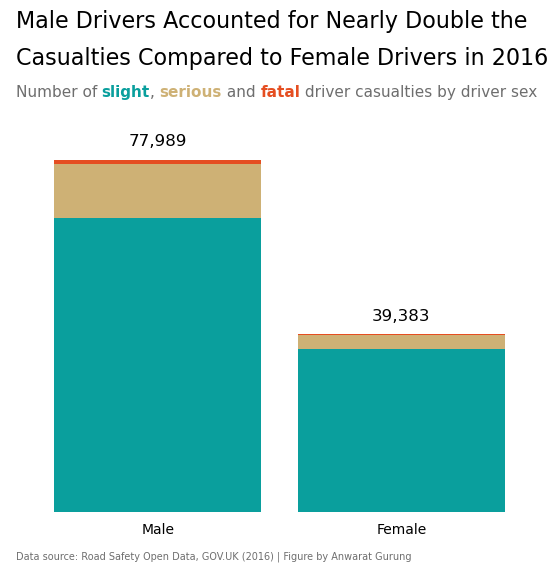

In [9]:
# choose a colour palette
cmap = load_cmap("AsteroidCity1")
colours = cmap.colors

# create a figure
fig, ax = plt.subplots()

# axes customisation
ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
ax.tick_params(axis="x", length=0, pad=8)
ax.set_yticks([])

# create a stacked bar chart
stack_order = ["slight", "serious", "fatal"]
bottom = np.zeros(df.shape[0])    # array to stack bars
for severity, colour in zip(stack_order, colours):
    ax.bar(
        df.index,
        df[severity],
        bottom=bottom,
        width=0.85,
        color=colour
    )
    bottom += df[severity].values

# annotate totals above each bar
totals = df.sum(axis=1)    # calculate totals per sex
for i, total in enumerate(totals):
    ax.text(
        x=i,
        y=total * 1.03 if i == 0 else total * 1.055,
        s=f"{total:,}",
        ha="center",
        va="bottom",
        fontsize=12,
        color="black"
    )

# chart title
x_value, y_value = 0.10, 1.04    # starting location of title text in figure coordinates
fig.text(
    x=x_value, y=y_value,
    s = "Male Drivers Accounted for Nearly Double the\nCasualties Compared to Female Drivers in 2016",
    fontsize=16,
    linespacing=1.8
)

# chart subtitle
fig_text(
    x=x_value, y=y_value * 0.96,
    s="Number of <slight>, <serious> and <fatal> driver casualties by driver sex",
    highlight_textprops=[
        {"color": colours[0], "weight": "bold"},
        {"color": colours[1], "weight": "bold"},
        {"color": colours[2], "weight": "bold"},
    ],
    fontsize=11,
    color="#6e6e6e"
)

# chart caption
fig.text(
    x_value, 0.005,
    "Data source: Road Safety Open Data, GOV.UK (2016) | Figure by Anwarat Gurung",
    ha="left",
    va="bottom",
    fontsize=7,
    color="#6e6e6e",
)

# save figure as an image file
plt.savefig("../images/casualty_severity_by_sex.png", dpi=200, bbox_inches="tight")

plt.show()